# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Charlotte Maschke
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Some setup and import

In [2]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
from mne import viz

# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

### Which subject do you want to preprocess? 

In [2]:
ID = "TACS01"
session = "01"
task = "post"

In [3]:
raw_path = "./Data/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_eeg.set".format(ID,session,ID,session,task)
raw_path

'./Data/sub-TACS01/ses-01/eeg/sub-TACS01_ses-01_task-post_eeg.set'

## Load the raw data!

In [4]:
raw = mne.io.read_raw_eeglab(raw_path)
raw

Reading c:\Users\VivoBook\Documents\GitHub\EEG_Preprocessing_TACS\Data\sub-TACS01\ses-01\eeg\sub-TACS01_ses-01_task-post_eeg.fdt


<RawEEGLAB | sub-TACS01_ses-01_task-post_eeg.fdt, 129 x 329585 (329.6 s), ~172 kB, data not loaded>

## Resample the data to 250

In [5]:
if raw.info['sfreq'] != 250:
    raw = raw.resample(250)

### Keep only the EEG

In [6]:
# this is to load EEG. If you want to load other stuff please refer to the website documetation
eeg = raw.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)

Number of channels in EEG:


129

## Crop the data

Depending on the data, we may need to crop the begining or/and the end

In [7]:
#eeg.plot(duration=30, title='raw')

Using matplotlib as 2D backend.


<MNEBrowseFigure size 800x749 with 4 Axes>

In [7]:
eeg_cropped= eeg.crop(tmin=5.0)
#eeg_cropped.plot(duration=30, title='cropped')

## Filter the data

In [1]:
# load actual data into system (before it was only metadata)
eeg_cropped.load_data()
#eeg.load_data()

# filter the data between 1 to 55 Hz
eeg_cropped_filtered = eeg_cropped.filter(l_freq=1, h_freq = 55)
#eeg_filtered = eeg.filter(l_freq=1, h_freq = 55) 

# notch filter the data for freq =60
eeg_notch = eeg_cropped_filtered.copy().notch_filter(freqs=60)
#eeg_notch = eeg_filtered.notch_filter(freqs=60)


NameError: name 'eeg_cropped' is not defined

In [85]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['E129'], fmax = 70)
plt.savefig('./out_figures/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_raw_filtered.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


## Visualize raw data to identify bad channels

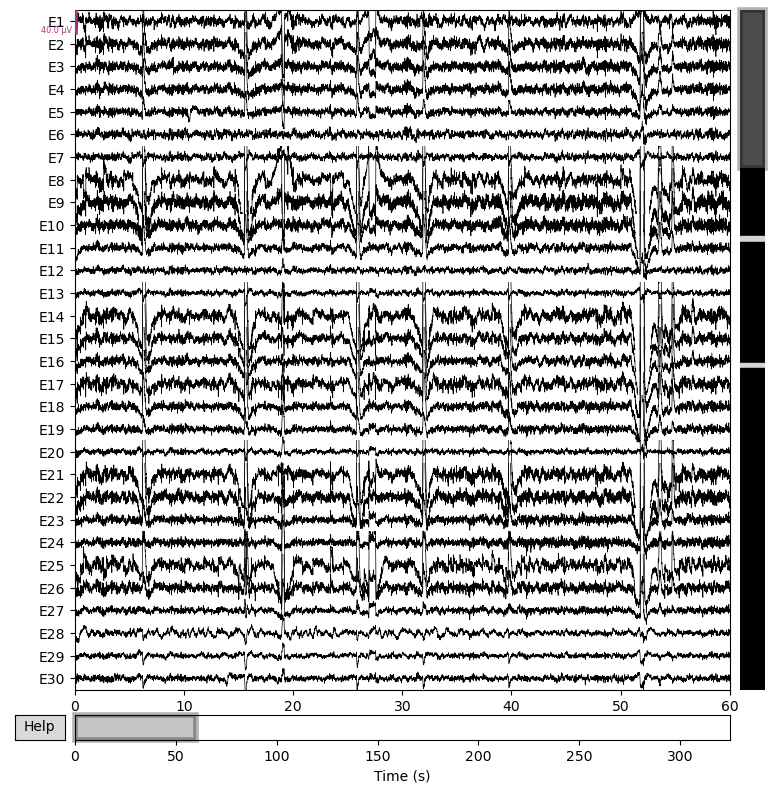

Channels marked as bad: ['E44', 'E68', 'E63', 'E73']


In [48]:
#eeg_notch.plot()
#eeg_filtered.plot(n_channels=30, duration=30)
eeg_notch.plot(n_channels=30, duration=60)

Verify if labelled correctly

In [49]:
marked_bad = eeg_notch.info['bads']
marked_bad

['E44', 'E68', 'E63', 'E73']

In [80]:
# save in a txt
with open('./eeg_output/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_marked_bads.json'.format(ID,session,ID,session,task), 'w') as outfile:
    outfile.write("\n".join(marked_bad))



# Interpolate bad channels

In [52]:
eeg_interpol = eeg_notch.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 9924.7 mm
Computing interpolation matrix from 125 sensor positions
Interpolating 4 sensors


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_10872\3839503059.py:1: RuntimeWarning: Estimated head size (9924.7 mm) exceeded 99th percentile for adult head size
  eeg_interpol = eeg_notch.interpolate_bads()
C:\Users\VivoBook\AppData\Local\Temp\ipykernel_10872\3839503059.py:1: RuntimeWarning: (X, Y) fit (-0.0, -59.3) more than 20 mm from head frame origin
  eeg_interpol = eeg_notch.interpolate_bads()


## Average Reference the data

In [53]:
# use the average of all channels as reference
eeg_avg_ref = eeg_interpol.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


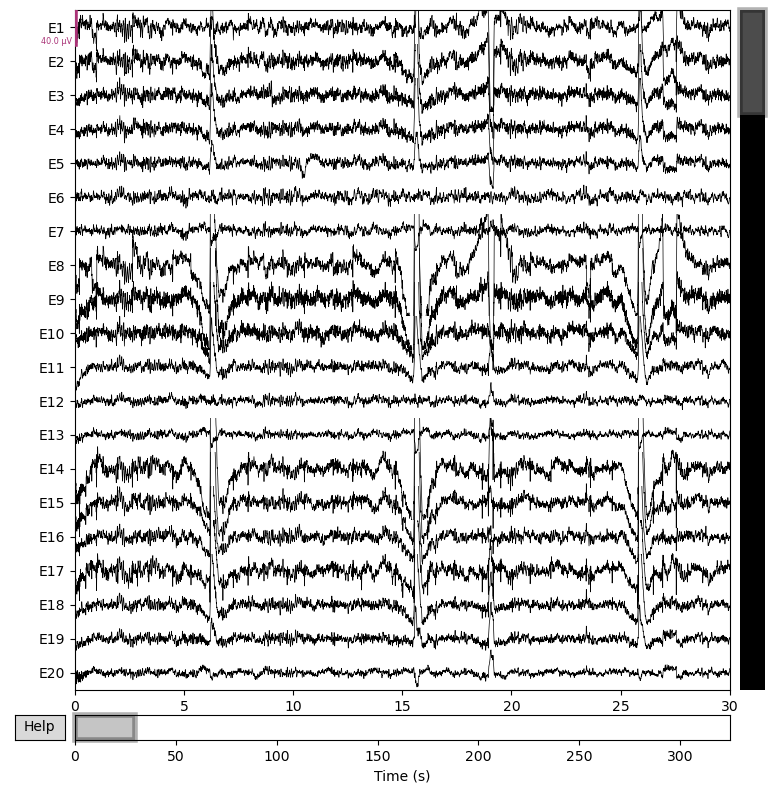

Channels marked as bad: none


In [54]:
eeg_avg_ref.plot(duration=30)

In [84]:
%matplotlib tk
viz.plot_raw_psd(eeg_avg_ref, fmax = 70)
plt.savefig('./out_figures/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_avg_ref.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


In [56]:
print(eeg_avg_ref.info)

<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG
 custom_ref_applied: True
 dig: 129 items (129 EEG)
 highpass: 1.0 Hz
 lowpass: 55.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 250.0 Hz
>


# RUN ICA

## Manual selection of ICA components

In [ ]:
# pick some channels that clearly show heartbeats and blinks
#eog_channels = ['E8', 'E12','E14','E21', 'E25', 'E126', 'E127']

In [57]:
#eeg_avg_ref.info['EOG channels']
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(eeg_avg_ref)

Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.9s.


Method,fastica
Fit,24 iterations on raw data (81146 samples)
ICA components,15
Explained variance,96.8 %
Available PCA components,129
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=15, n_times=81146
    Range : 1250 ... 82395 =      5.000 ...   329.580 secs
Ready.


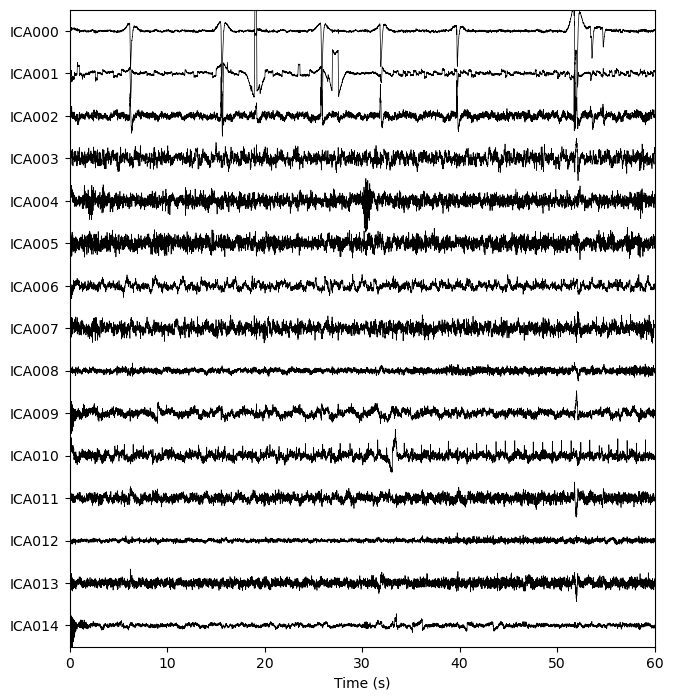

In [58]:
ica.plot_sources(eeg_avg_ref, show_scrollbars=False, stop = 60)


In [59]:
ica.plot_components()

[<MNEFigure size 975x731 with 15 Axes>]

In [60]:
ica

Method,fastica
Fit,24 iterations on raw data (81146 samples)
ICA components,15
Explained variance,96.8 %
Available PCA components,129
Channel types,eeg
ICA components marked for exclusion,ICA000ICA001ICA002


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 129 PCA components


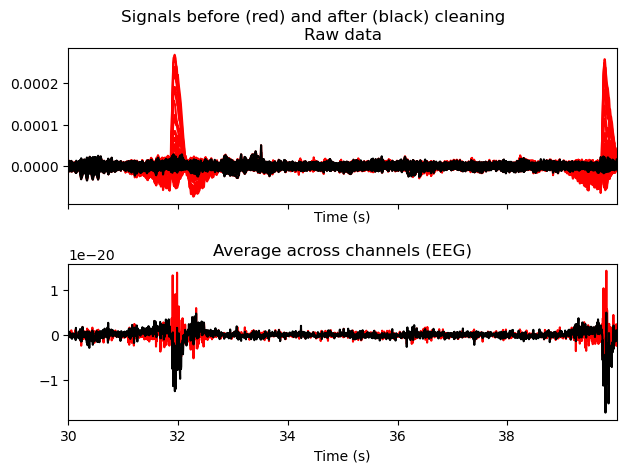

In [61]:
# blinks
ica.plot_overlay(eeg_avg_ref, start = 30*250, stop = 40*250)
#ica.plot_overlay(eeg_avg_ref, exclude=[0,1,2,3],start = 30*250, stop = 40*250)

Double check which component to remove: 

In [62]:
ica.exclude

[0, 1, 2]

Remove component definetely

In [63]:
eeg_postica = eeg_avg_ref.copy()
ica.apply(eeg_postica)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 129 PCA components


<RawEEGLAB | sub-TACS01_ses-01_task-post_eeg.fdt, 129 x 81146 (324.6 s), ~80.0 MB, data loaded>

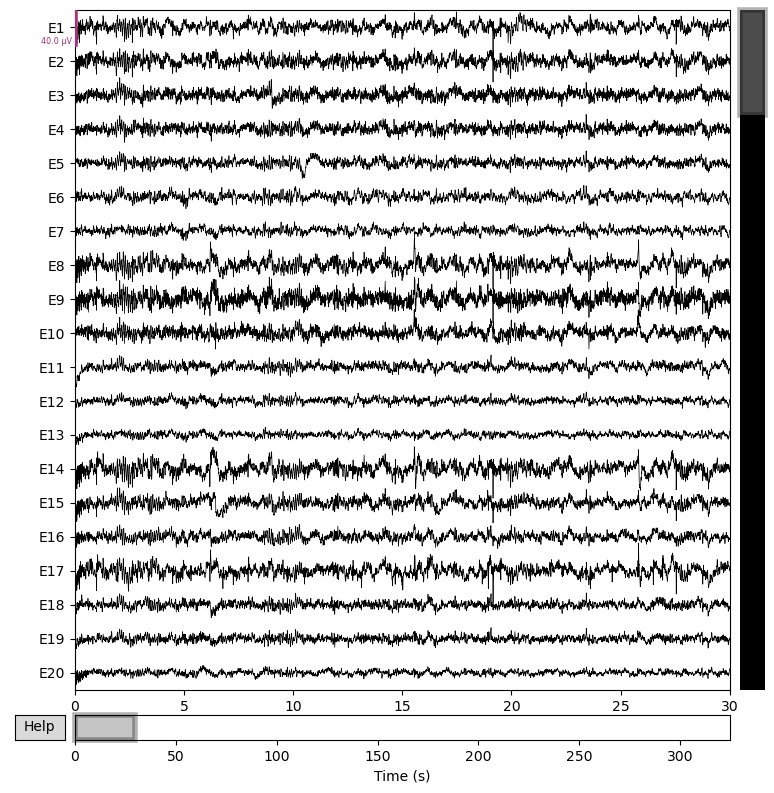

Channels marked as bad: none
Channels marked as bad: none


In [64]:
# PLot to compare both signals pre and post ICA
eeg_avg_ref.plot(title='raw', duration =30)
eeg_postica.plot(title='ICA correction', duration =30)

## Remove Non-Brain Electrodes and bad channels 

In [65]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e not in eeg_avg_ref.info['bads']:
        eeg_postica.info['bads'].append(e)


In [66]:
print(eeg_postica.info['bads'])

['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107']


In [69]:
# remove channels marked as bad and non-brain channels
eeg_brainonly = eeg_postica.copy().drop_channels(eeg_postica.info['bads'])
eeg_brainonly

<RawEEGLAB | sub-TACS01_ses-01_task-post_eeg.fdt, 105 x 81146 (324.6 s), ~65.2 MB, data loaded>

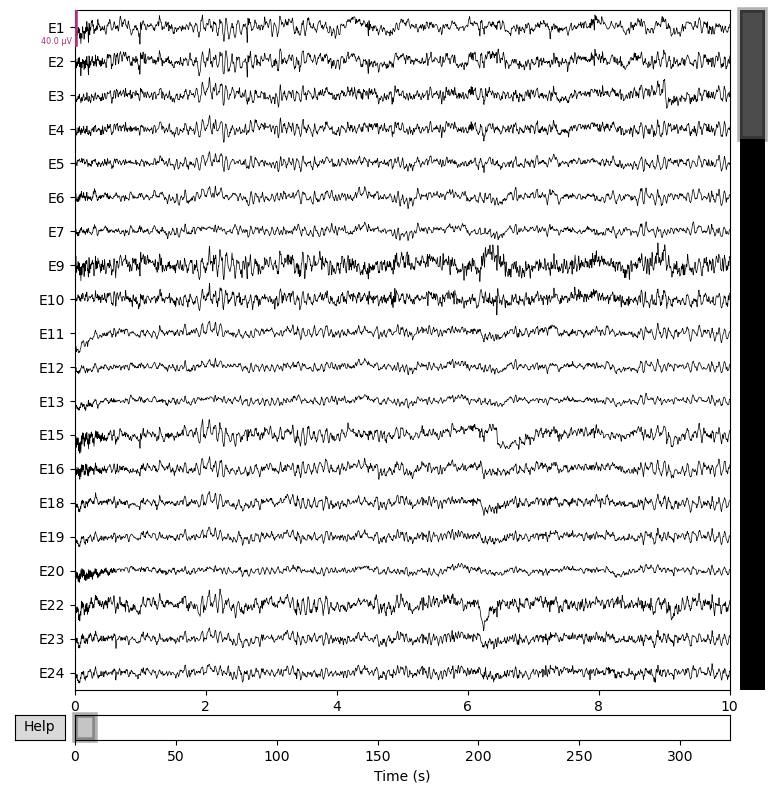

Channels marked as bad: none


In [70]:
eeg_brainonly.plot(title='brain only', duration=10)

## Save final non brain data

In [ ]:
#out_dir = pathlib.Path("./Results/sub-{}/ses-{}/eeg/".format(ID,session))

#if not os.path.exists(out_dir):
    #os.makedirs(out_dir)
    
#out_path = pathlib.Path(out_dir, "sub-{}_ses-{}_task-{}.set".format(ID,session,task))

In [71]:
eeg_brainonly.save("./eeg_output/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'nonbrainfiltered'), overwrite=True)
#ici changer pour le sauver dans derivatives, dossier clean (avec un readme expliquant le cleaning) et le fichier sous le bids format

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Writing c:\Users\VivoBook\Documents\GitHub\EEG_Preprocessing_TACS\eeg_output\sub-TACS01\ses-01\eeg\sub-TACS01_ses-01_task-post_nonbrainfiltered_eeg.fif
Closing c:\Users\VivoBook\Documents\GitHub\EEG_Preprocessing_TACS\eeg_output\sub-TACS01\ses-01\eeg\sub-TACS01_ses-01_task-post_nonbrainfiltered_eeg.fif
[done]


# Make epochs of 10 s

In [72]:
epochs = mne.make_fixed_length_epochs(eeg_brainonly, duration = 10, overlap=0)

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated


Loading data for 32 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 32 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...


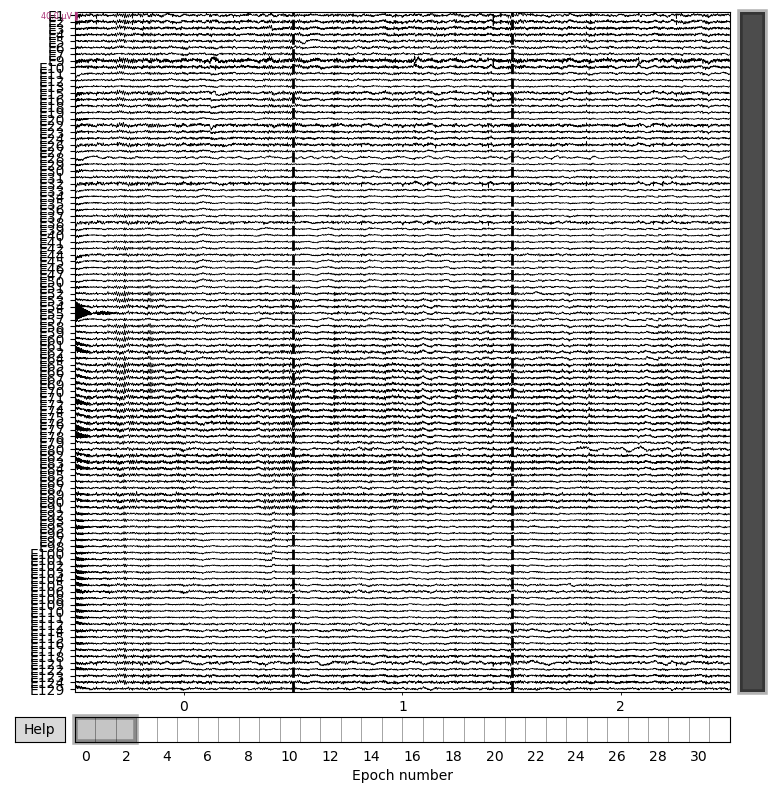

Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Dropped 0 epochs: 
Channels marked as bad: none


In [73]:
epochs.plot(n_epochs=3, n_channels=105, scalings=20e-6)

In [ ]:

# epochs.drop_bad()  double check on this


In [74]:
epochs

Number of events,32
Events,1: 32
Time range,0.000 – 9.996 sec
Baseline,off


In [75]:
epochs.save(("./eeg_output/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)


Loading data for 1 events and 2500 original time points ...
Loading data for 32 events and 2500 original time points ...


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_10872\4127031348.py:1: RuntimeWarning: This filename (./eeg_output/sub-TACS01/ses-01/eeg/sub-TACS01_ses-01_task-post_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(("./eeg_output/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)
